## Предобработка данных и логистическая регрессия для задачи бинарной классификации

## Programming assignment

Ознакомление с основными техниками предобработки данных, а так же применение их для обучения модели логистической регрессии. 

Для выполнения задания требуется Python версии 2.7, а также актуальные версии библиотек:
- NumPy: 1.10.4 и выше
- Pandas: 0.17.1 и выше
- Scikit-learn: 0.17 и выше

In [81]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
# import warnings
# warnings.filterwarnings('ignore')
%matplotlib inline

## Описание датасета

Задача: по 38 признакам, связанных с заявкой на грант (область исследований учёных, информация по их академическому бэкграунду, размер гранта, область, в которой он выдаётся) предсказать, будет ли заявка принята. Датасет включает в себя информацию по 6000 заявкам на гранты, которые были поданы в университете Мельбурна в период с 2004 по 2008 год.

Полную версию данных с большим количеством признаков можно найти на https://www.kaggle.com/c/unimelb.

In [82]:
data = pd.read_csv('data.csv')
data.shape

(6000, 39)

Выделим из датасета целевую переменную Grant.Status и обозначим её за y.
Теперь X обозначает обучающую выборку, y - ответы на ней.

In [83]:
X = data.drop('Grant.Status', 1)
y = data['Grant.Status']

## Предобработка данных

Из свойств данной модели следует, что:
- все $X$ должны быть числовыми данными (в случае наличия среди них категорий, их требуется некоторым способом преобразовать в вещественные числа)
- среди $X$ не должно быть пропущенных значений (т.е. все пропущенные значения перед применением модели следует каким-то образом заполнить)

Поэтому базовым этапом в предобработке любого датасета для логистической регрессии будет кодирование категориальных признаков, а так же удаление или интерпретация пропущенных значений.

In [84]:
data.head()

,Grant.Status,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,RFCD.Code.3,RFCD.Percentage.3,...,Dept.No..1,Faculty.No..1,With.PHD.1,No..of.Years.in.Uni.at.Time.of.Grant.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1,A..1,A.1,B.1,C.1
0,1,21A,50A,A,230202.0,50.0,230203.0,30.0,230204.0,20.0,...,3098.0,31.0,Yes,>=0 to 5,2.0,0.0,0.0,4.0,2.0,0.0
1,1,4D,10A,D,320801.0,100.0,0.0,0.0,0.0,0.0,...,2553.0,25.0,Yes,>=0 to 5,3.0,1.0,0.0,2.0,0.0,0.0
2,0,NaN,NaN,NaN,320602.0,50.0,321004.0,30.0,321015.0,20.0,...,2813.0,25.0,NaN,Less than 0,1.0,5.0,0.0,7.0,2.0,0.0
3,0,51C,20C,A,291503.0,60.0,321402.0,40.0,0.0,0.0,...,2553.0,25.0,NaN,more than 15,2.0,1.0,5.0,6.0,9.0,1.0
4,0,24D,30B,NaN,380107.0,100.0,0.0,0.0,0.0,0.0,...,2923.0,25.0,NaN,Less than 0,0.0,2.0,0.0,0.0,0.0,0.0


Видно, что в датасете есть как числовые, так и категориальные признаки. Получим списки их названий:

In [85]:
numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                'RFCD.Percentage.4', 'RFCD.Percentage.5',
                'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                'SEO.Percentage.4', 'SEO.Percentage.5',
                'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
categorical_cols = list(set(X.columns.values.tolist()) - set(numeric_cols))

Также в нём присутствуют пропущенные значения. Очевидным решением будет исключение всех данных, у которых пропущено хотя бы одно значение. Сделаем это:

In [86]:
data.dropna().shape

(213, 39)

Видно, что тогда мы выбросим почти все данные, и такой метод решения в данном случае не сработает.

Пропущенные значения можно интерпретировать, для этого существует несколько способов, они различаются для категориальных и вещественных признаков.

Для вещественных признаков:
- заменить на 0 (данный признак давать вклад в предсказание для данного объекта не будет)
- заменить на среднее (каждый пропущенный признак будет давать такой же вклад, как и среднее значение признака на датасете)

Для категориальных:
- интерпретировать пропущенное значение, как ещё одну категорию (данный способ является самым естественным, так как в случае категорий у нас есть уникальная возможность не потерять информацию о наличии пропущенных значений; обратите внимание, что в случае вещественных признаков данная информация неизбежно теряется)

## Обработка пропущенных значений.
1. Заполняем пропущенные вещественные значения в X нулями и средними по столбцам, назовем полученные датафреймы X_real_zeros и X_real_mean соответственно. Для подсчёта средних используем описанную ниже функцию calculate_means, которой требуется передать на вход вешественные признаки из исходного датафрейма.
2. Все категориальные признаки в X преобразуем в строки, пропущенные значения требуется также преобразовать в какие-либо строки, которые не являются категориями (например, 'NA'), полученный датафрейм назовем X_cat.

Для объединения выборок используем функции

    np.hstack(...)
    np.vstack(...)

In [87]:
def calculate_means(numeric_data):
    means = np.zeros(numeric_data.shape[1])
    for j in range(numeric_data.shape[1]):
        to_sum = numeric_data.iloc[:,j] 
        indices = np.nonzero(~numeric_data.iloc[:,j].isnull())[0] 
        for i in indices:
            means[j] += to_sum[i]
        means[j] /= indices.size
    return pd.Series(means, numeric_data.columns)

In [88]:
X_real_zeros = data[numeric_cols].fillna(0)
X_real_mean = data[numeric_cols].fillna(calculate_means(data[numeric_cols]))
X_cat = data[categorical_cols].fillna('NA')
X_cat = X_cat.astype(str)

## Преобразование категориальных признаков.

В предыдущей ячейке мы разделили наш датасет ещё на две части: в одной присутствуют только вещественные признаки, в другой только категориальные. Это понадобится для раздельной последующей обработке данных, а так же для сравнения качества работы тех или иных методов.

Для использования модели регрессии требуется преобразовать категориальные признаки в вещественные. Рассмотрим основной способ преоборазования категориальных признаков в вещественные: one-hot encoding. Его идея заключается в том, что мы преобразуем категориальный признак при помощи бинарного кода: каждой категории ставим в соответствие набор из нулей и единиц.

Кодирование признаков сильно увеличивает их количество, но полностью сохраняет информацию, в том числе о наличии пропущенных значений (их наличие просто становится одним из бинарных признаков в преобразованных данных).

Применим one-hot encoding к категориальным признакам. 
Функция

    encoder.fit_transform(X)
    
позволяет вычислить необходимые параметры преобразования, впоследствии к новым данным можно уже применять функцию

    encoder.transform(X)
    
Важно применять одинаковое преобразование как к обучающим, так и тестовым данным, потому что в противном случае получаются непредсказуемые, и, скорее всего, плохие результаты. В частности, если отдельно закодировать обучающую и тестовую выборку, то получатся разные коды для одних и тех же признаков, и решение работать не будет.

In [89]:
from sklearn.feature_extraction import DictVectorizer as DV

encoder = DV(sparse = False)
X_cat_oh = encoder.fit_transform(X_cat.T.to_dict().values())

Для построения метрики качества по результату обучения требуется разделить исходный датасет на обучающую и тестовую выборки.

In [90]:
from sklearn.model_selection import train_test_split

(X_train_real_zeros, 
 X_test_real_zeros, 
 y_train, y_test) = train_test_split(X_real_zeros, y, 
                                     test_size=0.3, 
                                     random_state=0)
(X_train_real_mean, 
 X_test_real_mean) = train_test_split(X_real_mean, 
                                      test_size=0.3, 
                                      random_state=0)
(X_train_cat_oh,
 X_test_cat_oh) = train_test_split(X_cat_oh, 
                                   test_size=0.3, 
                                   random_state=0)

## Описание классов

Итак, мы получили первые наборы данных, для которых выполнены оба ограничения логистической регрессии на входные данные. Обучим на них регрессию, используя имеющийся в библиотеке sklearn функционал по подбору гиперпараметров модели
    
    optimizer = GridSearchCV(estimator, param_grid)

где:
- estimator - обучающий алгоритм, для которого будет производиться подбор параметров
- param_grid - словарь параметров, ключами которого являются строки-названия, которые передаются алгоритму estimator, а значения - набор параметров для перебора

Данный класс выполняет кросс-валидацию обучающей выборки для каждого набора параметров и находит те, на которых алгоритм работает лучше всего. Этот метод позволяет настраивать гиперпараметры по обучающей выборке, избегая переобучения. Некоторые опциональные параметры вызова данного класса, которые нам понадобятся:
- scoring - функционал качества, максимум которого ищется кросс валидацией, по умолчанию используется функция score() класса esimator (доля верных ответов)
- n_jobs - позволяет ускорить кросс-валидацию, выполняя её параллельно, число определяет количество одновременно запущенных задач
- cv - количество фолдов, на которые разбивается выборка при кросс-валидации

После инициализации класса GridSearchCV, процесс подбора параметров запускается следующим методом:

    optimizer.fit(X, y)
    
На выходе для получения предсказаний можно пользоваться функцией

    optimizer.predict(X)
    
для меток или

    optimizer.predict_proba(X)
    
для вероятностей (в случае использования логистической регрессии).
    
Также можно напрямую получить оптимальный класс estimator и оптимальные параметры, так как они является атрибутами класса GridSearchCV:
- best\_estimator\_ - лучший алгоритм
- best\_params\_ - лучший набор параметров

Класс логистической регрессии выглядит следующим образом:

    estimator = LogisticRegression(penalty)
   
где penalty принимает либо значение 'l2', либо 'l1'. По умолчанию устанавливается значение 'l2'.

## Сравнение способов заполнения вещественных пропущенных значений.
1. Составим две обучающие выборки из вещественных и категориальных признаков: в одной вещественные признаки, где пропущенные значения заполнены нулями, в другой - средними. Рекомендуется записывать в выборки сначала вещественные, а потом категориальные признаки.
2. Обучаем на них логистическую регрессию, подбирая параметры из заданной сетки param_grid по методу кросс-валидации с числом фолдов cv=5. В качестве оптимизируемой функции используем заданную по умолчанию.
3. Построим два графика оценки точности +- ее стандратное отклонение в зависимости от гиперпараметра и убедимся, что действительно нашли её максимум. Обратим внимание на большую дисперсию получаемых оценок (уменьшить её можно увеличением числа фолдов cv, например взяв cv=10).
4. Получим две метрики качества AUC ROC на тестовой выборке и сравним их между собой.

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

def plot_scores(optimizer, title, xlabel, ylabel):
    scores=[]
    for i in range(len(optimizer.cv_results_['params'])):
        scores.append([optimizer.cv_results_['params'][i]['C'], 
                optimizer.cv_results_['mean_test_score'][i],
                optimizer.cv_results_['std_test_score'][i]])
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], color='blue', alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()    

In [98]:
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = 5

X_zeros_train = np.hstack((X_train_real_zeros, X_train_cat_oh))
X_means_train = np.hstack((X_train_real_mean, X_train_cat_oh))
X_zeros_test = np.hstack((X_test_real_zeros, X_test_cat_oh))
X_means_test = np.hstack((X_test_real_mean, X_test_cat_oh))

lr_est = LogisticRegression(max_iter=200)
grid_cv_zeros = GridSearchCV(lr_est, param_grid, cv=cv)
grid_cv_means = GridSearchCV(lr_est, param_grid, cv=cv)

grid_cv_zeros.fit(X_zeros_train, y_train)
grid_cv_means.fit(X_means_train, y_train)

zeros_pred = grid_cv_zeros.best_estimator_.predict_proba(X_zeros_test)[:,1]
means_pred = grid_cv_means.best_estimator_.predict_proba(X_means_test)[:,1]

roc_zeros = roc_auc_score(y_test, zeros_pred)
roc_means = roc_auc_score(y_test, means_pred)

максимум: 0.7992857142857143


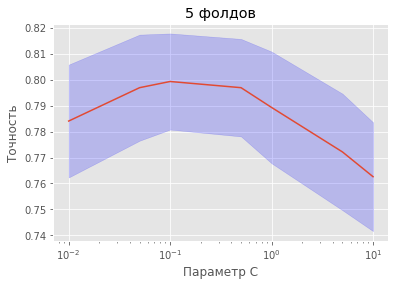

In [93]:
print("максимум:", grid_cv_zeros.best_score_)
plot_scores(grid_cv_zeros, "5 фолдов", "Параметр С", "Точность")

#### График точности для датасета с пропущенными значениями = среднему значению признака на выборке

максимум: 0.7978571428571428


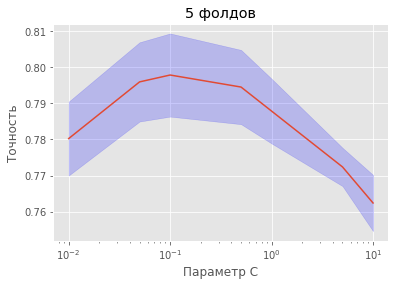

In [25]:
print("максимум:", grid_cv_means.best_score_)
plot_scores(grid_cv_means, "5 фолдов", "Параметр С", "Точность")

### Сравнение метрик

In [94]:
from sklearn.metrics import accuracy_score
print("Площадь под ROC-кривой для выборки со средним:", roc_means)
print("Площадь под ROC-кривой для выборки с нулями:", roc_zeros) 
print("accuracy для выборки со средним:", accuracy_score(y_test, grid_cv_means.best_estimator_.predict(X_means_test)))
print("accuracy для выборки с нулями:", accuracy_score(y_test, grid_cv_zeros.best_estimator_.predict(X_zeros_test)))

Площадь под ROC-кривой для выборки со средним: 0.8874473953506214
Площадь под ROC-кривой для выборки с нулями: 0.886526775317979
accuracy для выборки со средним: 0.8066666666666666
accuracy для выборки с нулями: 0.8083333333333333


Далее будем работать с выборкой, в которой пропуски заполнены нулями.

## Масштабирование вещественных признаков.

Попробуем как-то улучшить качество классификации. Для этого посмотрим на сами данные:

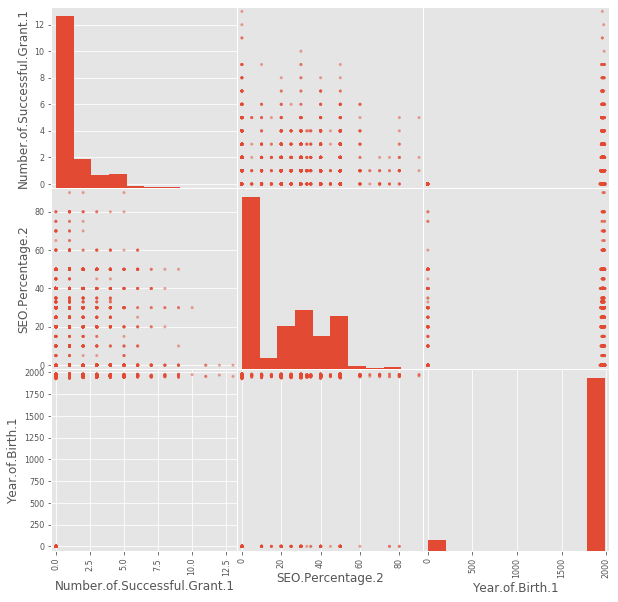

In [15]:
from pandas.plotting import scatter_matrix

data_numeric = pd.DataFrame(X_train_real_zeros, columns=numeric_cols)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

Как видно из графиков, разные признаки очень сильно отличаются друг от друга по модулю значений (обратите внимание на диапазоны значений осей x и y). В случае обычной регрессии это никак не влияет на качество обучаемой модели, т.к. у меньших по модулю признаков будут большие веса, но при использовании регуляризации, которая штрафует модель за большие веса, регрессия, как правило, начинает работать хуже.

В таких случаях всегда рекомендуется делать стандартизацию (масштабирование) признаков, для того чтобы они меньше отличались друг друга по модулю, но при этом не нарушались никакие другие свойства признакового пространства. При этом даже если итоговое качество модели на тесте уменьшается, это повышает её интерпретабельность, потому что новые веса имеют смысл "значимости" данного признака для итоговой классификации.

Стандартизация осуществляется посредством вычета из каждого признака среднего значения и нормировки на выборочное стандартное отклонение:

$$ x^{scaled}_{id} = \dfrac{x_{id} - \mu_d}{\sigma_d}, \quad \mu_d = \frac{1}{N} \sum_{i=1}^l x_{id}, \quad \sigma_d = \sqrt{\frac{1}{N-1} \sum_{i=1}^l (x_{id} - \mu_d)^2} $$

## Задание 1.5. Масштабирование вещественных признаков.

1. По аналогии с вызовом one-hot encoder применяем масштабирование вещественных признаков для обучающих и тестовых выборок X_train_real_mean и X_test_real_mean, используя класс 

        StandardScaler
   
   и методы 

        StandardScaler.fit_transform(...)
        StandardScaler.transform(...)

In [99]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_real_scaled = scaler.fit_transform(X_train_real_zeros)
X_test_real_scaled = scaler.transform(X_test_real_zeros)

## Сравнение признаковых пространств.

Построим такие же графики для преобразованных данных:

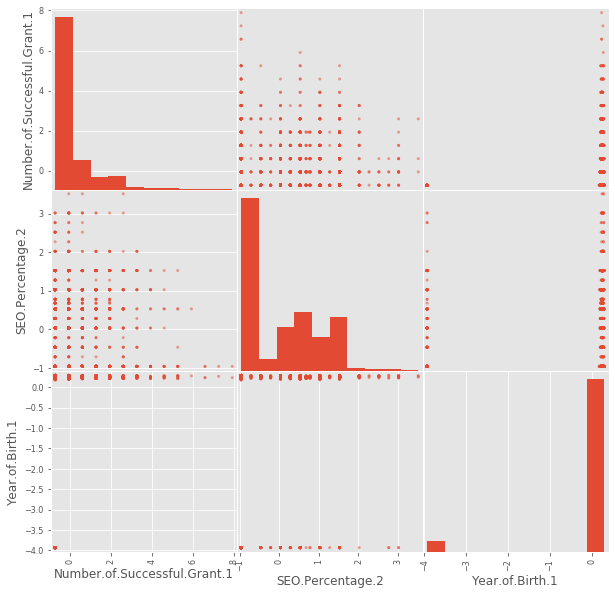

In [262]:
data_numeric_scaled = pd.DataFrame(X_train_real_scaled, columns=numeric_cols)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric_scaled[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

Как видно из графиков, мы не поменяли свойства признакового пространства: гистограммы распределений значений признаков, как и их scatter-plots, выглядят так же, как и до нормировки, но при этом все значения теперь находятся примерно в одном диапазоне, тем самым повышая интерпретабельность результатов.

## Сравнение качества классификации до и после масштабирования вещественных признаков.
1. Обучаем ещё раз регрессию и гиперпараметры на новых признаках, объединив их с закодированными категориальными.
2. Проверяем, был ли найден максимум accuracy по гиперпараметрам во время кроссвалидации.
3. Получаем значение ROC AUC на тестовой выборке, сравниваем с лучшим результатом, полученными ранее.

In [100]:
X_train_scaled = np.hstack((X_train_real_scaled, X_train_cat_oh))
X_test_scaled = np.hstack((X_test_real_scaled, X_test_cat_oh))

In [101]:
lr_est = LogisticRegression()
grid_cv_scaled = GridSearchCV(lr_est, param_grid, cv=cv)

grid_cv_scaled.fit(X_train_scaled, y_train)

scaled_pred = grid_cv_scaled.best_estimator_.predict_proba(X_test_scaled)[:,1]

roc_scaled = roc_auc_score(y_test, scaled_pred)

максимум после масштабирования: 0.799047619047619


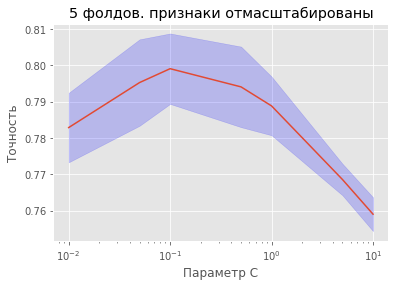

In [102]:
print("максимум после масштабирования:", grid_cv_scaled.best_score_)
plot_scores(grid_cv_scaled, "5 фолдов. признаки отмасштабированы", "Параметр С", "Точность")

In [103]:
print("Площадь под ROC-кривой без масштабирования:", roc_zeros) 
print("Площадь под ROC-кривой после масштабирования:", roc_scaled)
print("accuracy до масштабирования:", accuracy_score(y_test, grid_cv_zeros.best_estimator_.predict(X_means_test)))
print("accuracy после масштабирования:", accuracy_score(y_test, grid_cv_scaled.best_estimator_.predict(X_test_scaled)))

Площадь под ROC-кривой без масштабирования: 0.886526775317979
Площадь под ROC-кривой после масштабирования: 0.8870848393431426
accuracy до масштабирования: 0.8127777777777778
accuracy после масштабирования: 0.8077777777777778


Посмотрим на веса вещественных признаков:

In [104]:
grid_cv_scaled.best_estimator_.coef_[0][:13]

array([ 0.11653338,  0.06897088,  0.00376198, -0.05558579, -0.02351466,
       -0.05822584, -0.09351548, -0.01633361,  0.04744431, -0.02275383,
        0.13176617,  0.82241766, -1.13860095])

По значению весов можно сделать вывод, что наиболее значимыми признаками являются 2 последних, при этом положительное значение веса значимо для объектов класса "1", а отрицательное для объектов класса "0". Посмотрим на наши данные, выбранными признаками являются: количество одобренных ранее заявок на грант и количество заявок, которые не приняли, что вполне логично.

In [279]:
data[numeric_cols].head()

,RFCD.Percentage.1,RFCD.Percentage.2,RFCD.Percentage.3,RFCD.Percentage.4,RFCD.Percentage.5,SEO.Percentage.1,SEO.Percentage.2,SEO.Percentage.3,SEO.Percentage.4,SEO.Percentage.5,Year.of.Birth.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1
0,50.0,30.0,20.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,1965.0,2.0,0.0
1,100.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,1965.0,3.0,1.0
2,50.0,30.0,20.0,0.0,0.0,60.0,20.0,20.0,0.0,0.0,1955.0,1.0,5.0
3,60.0,40.0,0.0,0.0,0.0,60.0,40.0,0.0,0.0,0.0,1950.0,2.0,1.0
4,100.0,0.0,0.0,0.0,0.0,50.0,50.0,0.0,0.0,0.0,1970.0,0.0,2.0


## Балансировка классов.

Алгоритмы классификации могут быть очень чувствительны к несбалансированным классам. Поэтому на сбалансированность классов в обучающей выборке всегда следует обращать внимание.

Посмотрим, сбалансированны ли классы в нашей обучающей выборке:

In [35]:
print(np.sum(y_train==0))
print(np.sum(y_train==1))

2316
1884


Видно, что нет.

Исправить ситуацию можно разными способами, мы рассмотрим два:
- давать объектам миноритарного класса больший вес при обучении классификатора
- досэмплировать объекты миноритарного класса, пока число объектов в обоих классах не сравняется

## Балансировка классов.
1. Обучаем логистическую регрессию и гиперпараметры с балансировкой классов, используя веса (параметр class_weight='balanced' регрессии) на отмасштабированных выборках, полученных в предыдущем задании. Убеждаемся, что нашли максимум accuracy по гиперпараметрам.
2. Получаем метрику ROC AUC на тестовой выборке.
3. Сбалансируем выборку, досэмплировав в неё объекты из меньшего класса. Для получения индексов объектов, которые требуется добавить в обучающую выборку, используем следующую комбинацию вызовов функций:
        np.random.seed(0)
        indices_to_add = np.random.randint(...)
        X_train_to_add = X_train[y_train.as_matrix() == 1,:][indices_to_add,:]
   После этого добавляем эти объекты в начало или конец обучающей выборки. Дополняем соответствующим образом вектор ответов.
4. Получаем метрику ROC AUC на тестовой выборке, сравниваем с предыдущим результатом.

In [105]:
lr_est = LogisticRegression(class_weight='balanced')
grid_cv_balanced = GridSearchCV(lr_est, param_grid, cv=cv)

grid_cv_balanced.fit(X_train_scaled, y_train)

balanced_pred = grid_cv_balanced.best_estimator_.predict_proba(X_test_scaled)[:,1]

roc_balanced = roc_auc_score(y_test, balanced_pred)

максимум: 0.7921428571428571


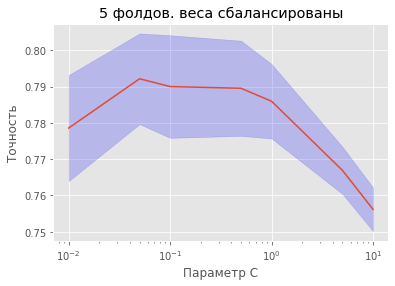

In [106]:
print("максимум:", grid_cv_balanced.best_score_)
plot_scores(grid_cv_balanced, "5 фолдов. веса сбалансированы", "Параметр С", "Точность")

In [107]:
print("Площадь под ROC-кривой со сбалансированными весами:", roc_balanced)
print("accuracy со сбалансированными весами:", accuracy_score(y_test, grid_cv_balanced.best_estimator_.predict(X_test_scaled)))

Площадь под ROC-кривой со сбалансированными весами: 0.8851458452690153
accuracy со сбалансированными весами: 0.8011111111111111


In [108]:
np.random.seed(0)
y1_size = np.sum(y_train == 1)
y0_size = np.sum(y_train == 0)

indices_to_add = np.random.randint(0, y1_size, size=(y0_size - y1_size))
X_train_to_add = X_train_scaled[y_train.as_matrix() == 1,:][indices_to_add,:]

X_train_sampled = np.vstack((X_train_scaled, X_train_to_add))
y_to_add = np.array([1]*(y0_size - y1_size))
y_train_sampled = np.hstack((y_train, y_to_add))

lr_est = LogisticRegression()
grid_cv_sampled = GridSearchCV(lr_est, param_grid, cv=cv)

grid_cv_sampled.fit(X_train_sampled, y_train_sampled)

sampled_pred = grid_cv_sampled.best_estimator_.predict_proba(X_test_scaled)[:,1]

roc_sampled = roc_auc_score(y_test, sampled_pred)

максимум: 0.8093696027633851


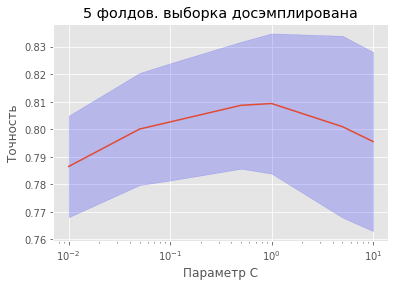

In [109]:
print("максимум:", grid_cv_sampled.best_score_)
plot_scores(grid_cv_sampled, "5 фолдов. выборка досэмплирована", "Параметр С", "Точность")

In [110]:
print("Площадь под ROC-кривой со сбалансированными весами:", roc_balanced)
print("Площадь под ROC-кривой с досэмплированным классом:", roc_sampled)
print("accuracy со сбалансированными весами:", accuracy_score(y_test, grid_cv_balanced.best_estimator_.predict(X_test_scaled)))
print("accuracy с досэмплированным классом:", accuracy_score(y_test, grid_cv_sampled.best_estimator_.predict(X_test_scaled)))

Площадь под ROC-кривой со сбалансированными весами: 0.8851458452690153
Площадь под ROC-кривой с досэмплированным классом: 0.8832711956057717
accuracy со сбалансированными весами: 0.8011111111111111
accuracy с досэмплированным классом: 0.8105555555555556


## Стратификация выборки.

Алгоритм логистический регрессии чувствителен к балансировке классов в обучающей выборке. Метрика классификатора на тесте имела бы гораздо больший смысл, если бы объекты были разделы в выборках поровну.

1. Разобьем выборки X_real_mean и X_cat_oh на обучение и тест, передавая в функцию 
        train_test_split(...)
   дополнительно параметр 
       stratify=y
   Также о передаем в функцию переменную random_state=0.
2. Выполним масштабирование новых вещественных выборок, обучим классификатор и его гиперпараметры при помощи метода кросс-валидации, делая поправку на несбалансированные классы при помощи весов. Убедимся в том, что нашли максимум accuracy по гиперпараметрам.
3. Оценим качество классификатора по метрике AUC ROC на тестовой выборке.

In [111]:
(X_train_real_zeros, 
 X_test_real_zeros, 
 y_train, y_test) = train_test_split(X_real_zeros, y, test_size=0.3,                                      
                                     random_state=0, stratify=y)
(X_train_cat_oh,
 X_test_cat_oh) = train_test_split(X_cat_oh, test_size=0.3,
                                   random_state=0, stratify=y)

scaler = StandardScaler()
X_train_real_scaled = scaler.fit_transform(X_train_real_zeros)
X_test_real_scaled = scaler.transform(X_test_real_zeros)

X_train = np.hstack((X_train_real_scaled, X_train_cat_oh))
X_test = np.hstack((X_test_real_scaled, X_test_cat_oh))

lr_est = LogisticRegression(class_weight='balanced')
grid_cv_strat = GridSearchCV(lr_est, param_grid, cv=cv)

grid_cv_strat.fit(X_train, y_train)

strat_pred = grid_cv_strat.best_estimator_.predict_proba(X_test)[:,1]

roc_strat = roc_auc_score(y_test, strat_pred)

максимум: 0.8057142857142857


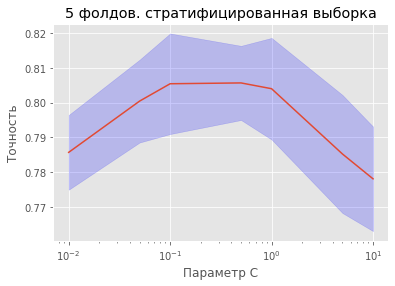

In [112]:
print("максимум:", grid_cv_strat.best_score_)
plot_scores(grid_cv_strat, "5 фолдов. стратифицированная выборка", "Параметр С", "Точность")

In [113]:
print("Площадь под ROC-кривой со стратифицированным разбиением:", roc_strat)
print("accuracy со стратифицированным разбиением:", accuracy_score(y_test, grid_cv_strat.best_estimator_.predict(X_test)))

Площадь под ROC-кривой со стратифицированным разбиением: 0.8783249742510412
accuracy со стратифицированным разбиением: 0.7955555555555556


## Трансформация признаков.

Теперь рассмотрим способы преобразования признаков. Существует достаточно много различных способов трансформации признаков, которые позволяют при помощи линейных методов получать более сложные разделяющие поверхности. Самым базовым является полиномиальное преобразование признаков. Его идея заключается в том, что помимо самих признаков вы дополнительно включаете набор все полиномы степени $p$, которые можно из них построить. Для случая $p=2$ преобразование выглядит следующим образом:

$$ \phi(x_i) = [x_{i,1}^2, ..., x_{i,D}^2, x_{i,1}x_{i,2}, ..., x_{i,D} x_{i,D-1}, x_{i,1}, ..., x_{i,D}, 1] $$

Добавление полиномов от признаков позволяет строить нелинейные разделяющие поверхности, которые могут лучше подстраиваться под данные и находить более сложные зависимости.

С другой стороны, с увеличением степени $p$ из-за быстрого роста числа признаков модель будет быстрее переобучаться

## Трансформация вещественных признаков.

1. Реализуем преобразование вещественных признаков модели при помощи полиномиальных признаков степени 2
2. Построим логистическую регрессию на новых данных, одновременно подобрав оптимальные гиперпараметры. Для обучения используем стратифицированные выборки с балансировкой классов при помощи весов, преобразованные признаки требуется заново отмасштабировать.
3. Получим AUC ROC на тесте и сравним данный результат с использованием обычных признаков.

In [114]:
from sklearn.preprocessing import PolynomialFeatures
transform = PolynomialFeatures(2)
X_train_poly = transform.fit_transform(X_train_real_zeros)
X_test_poly = transform.transform(X_test_real_zeros)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

X_train = np.hstack((X_train_scaled, X_train_cat_oh))
X_test = np.hstack((X_test_scaled, X_test_cat_oh))

lr_est = LogisticRegression(class_weight='balanced', fit_intercept=False)
grid_cv_poly = GridSearchCV(lr_est, param_grid, cv=cv)

grid_cv_poly.fit(X_train, y_train)

poly_pred = grid_cv_poly.best_estimator_.predict_proba(X_test)[:,1]

roc_poly = roc_auc_score(y_test, poly_pred)

максимум: 0.809047619047619


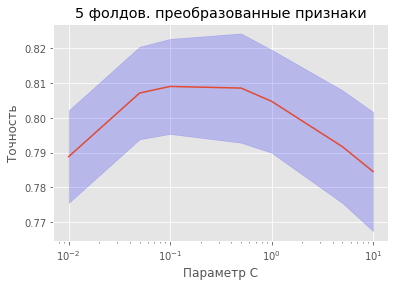

In [115]:
print("максимум:", grid_cv_poly.best_score_)
plot_scores(grid_cv_poly, "5 фолдов. преобразованные признаки", "Параметр С", "Точность")

In [116]:
print("Площадь под ROC-кривой без преобразования:", roc_strat)
print("Площадь под ROC-кривой с преобразованными признаками:", roc_poly)
print("accuracy без преобразования: 0.7866666666666666")
print("accuracy с преобразованными признаками:", accuracy_score(y_test, grid_cv_poly.best_estimator_.predict(X_test)))

Площадь под ROC-кривой без преобразования: 0.8783249742510412
Площадь под ROC-кривой с преобразованными признаками: 0.8869913025739007
accuracy без преобразования: 0.7866666666666666
accuracy с преобразованными признаками: 0.7944444444444444


Качество несколько выросло.

## Регрессия Lasso.
К логистической регрессии также можно применить L1-регуляризацию (Lasso), вместо регуляризации L2, которая будет приводить к отбору признаков. Применим L1-регуляцию к исходным признакам и проинтерпретировать полученные результаты (применение отбора признаков к полиномиальным так же можно успешно применять, но в нём уже будет отсутствовать компонента интерпретации, т.к. смысловое значение оригинальных признаков известно, а полиномиальных - уже может быть достаточно нетривиально). Для вызова логистической регрессии с L1-регуляризацией достаточно передать параметр penalty='l1' в инициализацию класса.

## Отбор признаков при помощи регрессии Lasso.
1. Обучим регрессию Lasso на стратифицированных отмасштабированных выборках, используя балансировку классов при помощи весов.
2. Получим ROC AUC регрессии, сравним его с предыдущими результатами.
3. Найдем номера вещественных признаков, которые имеют нулевые веса в итоговой модели.

In [117]:
(X_train_real_zeros, 
 X_test_real_zeros, 
 y_train, y_test) = train_test_split(X_real_zeros, y, test_size=0.3,                                      
                                     random_state=0, stratify=y)
(X_train_cat_oh,
 X_test_cat_oh) = train_test_split(X_cat_oh, test_size=0.3,
                                   random_state=0, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_real_zeros)
X_test_scaled = scaler.transform(X_test_real_zeros)

X_train = np.hstack((X_train_scaled, X_train_cat_oh))
X_test = np.hstack((X_test_scaled, X_test_cat_oh))

lr_est = LogisticRegression(solver='liblinear', penalty='l1', class_weight='balanced')
grid_cv_l1 = GridSearchCV(lr_est, param_grid, cv=cv)

grid_cv_l1.fit(X_train, y_train)

l1_pred = grid_cv_l1.best_estimator_.predict_proba(X_test)[:,1]

roc_l1 = roc_auc_score(y_test, l1_pred)

In [118]:
print("Площадь под ROC-кривой с Лассо:", roc_l1)

Площадь под ROC-кривой с Лассо: 0.8764665711342977


In [120]:
zero_weight = []
for i in range(13):
    if grid_cv_l1.best_estimator_.coef_[0][i] == 0:
        zero_weight.append(i)

In [121]:
zero_weight

[4, 6, 7]

Так как в массиве элементы нумеруются начиная с 0, регуляризатор обнулил веса признаков 5, 7 и 8. Эти признаки отвечают за процент работы, имеющий отношение к той или иной научной области. Отсюда можно сделать вывод, что данные науные направления слабо связаны с областью выдачи гранта.